In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import sampler
import torchvision.models as models


Load and process CIFAR 10 data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

Files already downloaded and verified
Files already downloaded and verified


Look at example CIFAR images

<IPython.core.display.Javascript object>


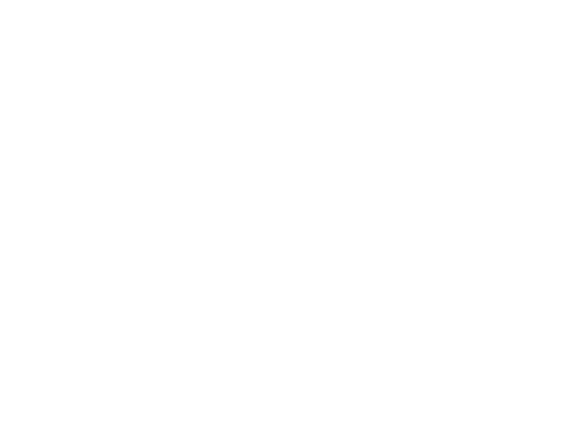

 bird   dog  deer  bird


Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
    r = index_queue.get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 376, in get
    return recv()
    racquire()
  File "/usr/local/lib/py

In [3]:
%matplotlib nbagg
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Define wrappers for masking out weights

In [4]:
'''
Modified from https://github.com/ChristopherSweeney/pytorch-weights_pruning
'''

class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.mask = to_var(mask, requires_grad=False)
        self.weight.data = self.weight.data*self.mask.data
        self.mask_flag = True
    
    def get_mask(self):
        print(self.mask_flag)
        return self.mask
    
    def forward(self, x):
        if self.mask_flag == True:
            weight = self.weight*self.mask
            return F.linear(x, weight, self.bias)
        else:
            return F.linear(x, self.weight, self.bias)
        
        
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, 
            kernel_size, stride, padding, dilation, groups, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.mask = to_var(mask, requires_grad=False)
        self.weight.data = self.weight.data*self.mask.data
        self.mask_flag = True
    
    def get_mask(self):
        print(self.mask_flag)
        return self.mask
    
    def forward(self, x):
        if self.mask_flag == True:
            weight = self.weight*self.mask
            return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
        else:
            return F.conv2d(x, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
        

In [5]:
'''
Modified from https://github.com/pytorch/vision.git
'''

import math
import torch.nn as nn
import torch.nn.init as init

__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]
#make vgg with masked layers
class VGG(nn.Module):
    def __init__(self, features,width=512,classes=10):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            MaskedLinear(width,width),
            nn.ReLU(True),
            nn.Dropout(),
            MaskedLinear(width, width),
            nn.ReLU(True),
            nn.Dropout(),
            MaskedLinear(width, classes),
        )
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = MaskedConv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
    'T': [2, 'M', 4, 'M', 8, 8, 'M', 16, 16, 'M', 16, 16, 'M'],
}
def vgg_lite():
    return VGG(make_layers(cfg['T']),width=16)

def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))

def vgg11_bn():
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True))


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

In [6]:
def to_var(x, requires_grad=False, volatile=False):
    """
    Varialbe type that automatically choose cpu or cuda
    """
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad, volatile=volatile)

def prune_rate(model, verbose=True):
    """
    adapted from https://github.com/ChristopherSweeney/pytorch-weights_pruning
    """
    total_nb_param = 0
    nb_zero_param = 0

    layer_id = 0

    for parameter in model.parameters():

        param_this_layer = 1
        for dim in parameter.data.size():
            param_this_layer *= dim
        total_nb_param += param_this_layer

        # only pruning linear and conv layers
        if len(parameter.data.size()) != 1:
            layer_id += 1
            zero_param_this_layer = \
                np.count_nonzero(parameter.cpu().data.numpy()==0)
            nb_zero_param += zero_param_this_layer

            if verbose:
                print("Layer {} | {} layer | {:.2f}% parameters pruned" \
                    .format(
                        layer_id,
                        'Conv' if len(parameter.data.size()) == 4 \
                            else 'Linear',
                        100.*zero_param_this_layer/param_this_layer,
                        ))
    pruning_perc = 100.*nb_zero_param/total_nb_param
    if verbose:
        print("Final pruning rate: {:.2f}%".format(pruning_perc))
    return pruning_perc

create model

In [209]:
w = torch.load("/home/drc/Downloads/model_best.pth.tar")
w = w['state_dict']

In [210]:
for key in w.keys()[:32]:
    new_key = key.split(".")
    nkey = new_key[0]+'.'+new_key[2]+'.'+new_key[3]
    w[nkey] = w[key]
    del w[key]

In [211]:
w['classifier.0.weight'] =w['classifier.1.weight']
w['classifier.0.bias'] = w['classifier.1.bias']
w['classifier.3.weight'] = w['classifier.4.weight']
w['classifier.3.bias'] = w['classifier.4.bias']
del w['classifier.1.bias']
del w['classifier.4.bias']
del w['classifier.1.weight']
del w['classifier.4.weight']


In [212]:
import torch.utils.model_zoo as model_zoo
vgg_model = vgg19()
#sd = torch.load('/home/drc/Downloads/model_best.pth.tar')
vgg_model.load_state_dict(w)
vgg_model = vgg_model.cuda()
import copy
model = copy.deepcopy(vgg_model)

In [213]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [79]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for t, (x, y) in enumerate(trainloader):
        inputs, labels = to_var(x), to_var(y.long())
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if t % 2000 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, t + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.000
[1,  2001] loss: 0.704


Process Process-60:
    return recv()
Process Process-59:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    self._target(*self._args, **self._kwargs)
    r = index_queue.get()
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 378, in get
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python2.7/dist-packages/torch/multiprocessing/queue.py", line 21, in recv
  File "/usr/

KeyboardInterrupt: 

In [40]:
def test(model, loader):

    model.eval()

    num_correct, num_samples = 0, len(loader.dataset)
    for x, y in loader:
        x_var = to_var(x, volatile=True)
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()

    acc = float(num_correct) / num_samples

    print('Test accuracy: {:.2f}% ({}/{})'.format(
        100.*acc,
        num_correct,
        num_samples,
        ))
    
    return acc


In [167]:
test(model,testloader)

Test accuracy: 80.70% (8070/10000)


0.807

In [141]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images, labels = to_var(images), labels.long()

    outputs = vgg_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


TypeError: eq received an invalid combination of arguments - got (torch.LongTensor), but expected one of:
 * (int value)
      didn't match because some of the arguments have invalid types: ([31;1mtorch.LongTensor[0m)
 * (torch.cuda.LongTensor other)
      didn't match because some of the arguments have invalid types: ([31;1mtorch.LongTensor[0m)


In [61]:
prune_rate(model)

Layer 1 | Conv layer | 38.89% parameters pruned
Layer 2 | Conv layer | 37.50% parameters pruned
Layer 3 | Conv layer | 38.54% parameters pruned
Layer 4 | Conv layer | 39.24% parameters pruned
Layer 5 | Conv layer | 39.15% parameters pruned
Layer 6 | Conv layer | 39.58% parameters pruned
Layer 7 | Conv layer | 39.58% parameters pruned
Layer 8 | Conv layer | 39.58% parameters pruned
Layer 9 | Linear layer | 40.23% parameters pruned
Layer 10 | Linear layer | 39.45% parameters pruned
Layer 11 | Linear layer | 36.25% parameters pruned
Final pruning rate: 38.91%


38.90805764156688

(64, 3, 3, 3)
(64, 64, 3, 3)
(128, 64, 3, 3)
(128, 128, 3, 3)
(256, 128, 3, 3)
(256, 256, 3, 3)
(256, 256, 3, 3)
(256, 256, 3, 3)
(512, 256, 3, 3)
(512, 512, 3, 3)
(512, 512, 3, 3)
(512, 512, 3, 3)
(512, 512, 3, 3)
(512, 512, 3, 3)
(512, 512, 3, 3)
(512, 512, 3, 3)


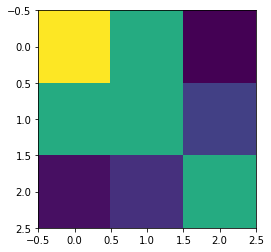

In [337]:
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
mm = model.cuda().double()
filters = mm.modules
layers=np.zeros((3,3))
body_model = [i for i in mm.children()][0]
for i in body_model:
    if isinstance(i,MaskedConv2d):
        tensor = i.weight.cpu().data.numpy()
        shape = np.shape(tensor)
        print shape
tensor = layer1.weight.cpu().data.numpy()
plt.figure()
plt.imshow(tensor[0][0])

In [333]:
body_model

Sequential(
  (0): MaskedConv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): MaskedConv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): MaskedConv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): MaskedConv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): MaskedConv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): MaskedConv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): MaskedConv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaskedConv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel

In [147]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model = model.float()
for data in testloader:
    images, labels = data
    images, labels = to_var(images),labels
    outputs = vgg_model(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted.cpu().numpy() == labels.numpy()).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane :  2 %
Accuracy of   car :  1 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer : 69 %
Accuracy of   dog : 25 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %


In [236]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model = model.float()
for data in testloader:
    images, labels = data
    images, labels = to_var(images),labels
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted.cpu().numpy() == labels.numpy()).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship : 100 %
Accuracy of truck :  0 %


In [ ]:
modules = list(self.model.modules())
        for i in range(1,len(modules)):
            model_sizes = []
            current_mod = modules[i]
            params = list(current_mod.parameters())
            for j in range(len(params)):
                parameters = params[j].data.cpu().numpy()
                non_zero = parameters[parameters>0]
                model_sizes.append(np.size(parameters))
        num_bits = 0
        bits = 32 #32 bit floats
        for i in range(len(model_sizes)):
            s = model_sizes[i]
            bits = np.prod(np.array(s))*bits
            num_bits += bits
        print(num_bits)
        return num_bits

In [178]:
class PruneWrapSparse():
    def __init__(self,train_start,model,sparsity_initial,sparsity_target,prune_steps,update_rate,train):
        #model params
        self.model = model.float()
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_loader = train
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.0001, momentum=0.9)
        
        #bookkeeping
        self.current_sparsity=0
        self.sparsity_target = sparsity_target
        self.sparsity_initial = sparsity_initial
        self.train_step = train_start
        self.prune_steps =prune_steps
        self.update_rate = update_rate
        self.prunning = True
        self.running_loss = 0
        self.loss_over_time=[]
        self.sparsity_over_time=[]
        
    def to_string(self):
        print "current sparsity: " + str(self.current_sparsity)
        print "sparsity target: "+ str(self.sparsity_target)
        print "initial sparsity: " + str(self.sparsity_initial)
        print "current train step: "+ str(self.train_step)
        print "prune steps: "+str(self.prune_steps)
        print "prunning rate: "+str(self.update_rate)
        
    def test(self,test_data_loader):
        self.model.eval()
        
        correct, samples = 0, len(test_data_loader.dataset)
        for x, y in test_data_loader:
            x_var = to_var(x, volatile=True)
            scores = self.model(x_var)
            _, preds = scores.data.cpu().max(1)
            correct += (preds == y).sum()

        return float(correct)/samples
    
    def reset(self):
        self.current_sparsity=0.
        self.train_step = 0.
        self.current_sparsity = 0.
    
    def compute_current_target(self):
        return self.sparsity_target+(self.sparsity_initial-self.sparsity_target)*(1-(float(self.train_step)/(self.prune_steps*self.update_rate)))**3
    
    def train(self, optimizer = None, epoches = 10):
        start = time.time()
        for i in range(epoches):
            print self.to_string()
            print "epoch: ", i
            print self.current_sparsity
            for batch, label in self.train_loader:
                #stop prunning?
                if self.prunning and self.current_sparsity >= self.sparsity_target:
                    self.prunning = False
                    print "finished prunning"
                #should i prune?
                if self.train_step%self.update_rate==0:
                    print self.train_step
                    print self.running_loss/float(self.update_rate)
                    if self.prunning:
                        self.prune()
                    self.running_loss = 0.0
                    print prune_rate(self.model)

                #train
                batch,label = (to_var(batch),to_var(label))
                self.optimizer.zero_grad()
                loss = self.criterion(self.model(batch), label)
                loss.backward()
                self.optimizer.step()
                self.running_loss+=loss.data[0]
                self.train_step+=1
              
            print prune_rate(self.model)
            print self.test(testloader)
        print "Finished fine tuning."
        print "Time elapsed:" + str((time.time() - start))

    def prune(self):#all conv layers for now
        current_sparsity_target = self.compute_current_target()
        print current_sparsity_target
        print self.to_string()
        for seq in list(self.model.children()):
            for layer in seq:
                if isinstance(layer, MaskedLinear) or isinstance(layer, MaskedConv2d):
                    #find weight threshold for layer
                    weight_threshold = self.get_weight_threshold(layer.parameters(),current_sparsity_target) 
                    #set mask
                    mask = self.get_prune_mask(layer,weight_threshold)
                    #prune
                    layer.set_mask(mask)
        self.sparsity_over_time.append(current_sparsity_target)
        self.current_sparsity = current_sparsity_target # more accurate actually figure out hw much was prunned
        self.loss_over_time.append(self.running_loss/float(self.update_rate))
    
        
    def get_prune_mask(self,layer,threshold):
        # generate mask
        p=layer.weight.data.abs()
        pruned_inds = p > threshold
        return pruned_inds.float()
        
    def save_weight_hist(self,params):
        params = []
        plt.figure()
        for p in self.model.parameters():
            params.extend(list(p.data.cpu().abs().numpy().flatten()))
        plt.hist(params,bins=100,range=[0, 1])
        plt.show()
        
    def get_weight_threshold(self,params,percent_to_prune):
        weights=[]
        for param in params:
            if len(list(param.cpu().data.abs().numpy().flatten()))>1:
                weights.extend(list(param.cpu().data.abs().numpy().flatten()))
        threshold = np.percentile(np.array(weights),percent_to_prune*100)
        #print len(np.nonzero(np.array(weights)))/float(len(weights))
        return threshold

    def calculate_current_model_size(self):
        total_nb_param = 0
        non_zero_param = 0
        for parameter in self.model.parameters():
            total_nb_param += np.size(parameter.cpu().data.abs().numpy())
            non_zero_param += np.count_nonzero(parameter.cpu().data.abs().numpy()>0)
        print "model sparsity: ", 1-float(non_zero_param)/total_nb_param
        bits = 32 #32 bit floats
        return bits*non_zero_param
   
    def calculate_current_model_inference_time(self,samples=10):
        time_sum =0
        for i in range(samples):
            (batch, label) = next(iter(self.train_loader))
            input = to_var(batch.float())
            start = time.time()
            output = self.model(input)
            time_sum+=time.time() - start
        print "Time elapsed:" + str((time_sum/float(samples)))    
            

In [283]:
epoch_start,model,sparsity_initial,sparsity_target,prune_steps,update_rate,train,gpu=False):

SyntaxError: invalid syntax (<ipython-input-283-6e4a567f749a>, line 1)

In [214]:
print prune.calculate_current_model_size()
print prune.calculate_current_model_inference_time(10)

model sparsity:  0.749927243364
657754432
Time elapsed:0.00445837974548
None


In [175]:
print prune.calculate_current_model_size()
print prune.calculate_current_model_inference_time(10)

model sparsity:  1.0
657754432
Time elapsed:0.00456907749176
None


In [215]:
prune = PruneWrapSparse(0,model,0,.4,100,1000,trainloader)

In [216]:
prune_rate(model)

Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Conv layer | 0.00% parameters pruned
Layer 5 | Conv layer | 0.00% parameters pruned
Layer 6 | Conv layer | 0.00% parameters pruned
Layer 7 | Conv layer | 0.00% parameters pruned
Layer 8 | Conv layer | 0.00% parameters pruned
Layer 9 | Conv layer | 0.00% parameters pruned
Layer 10 | Conv layer | 0.00% parameters pruned
Layer 11 | Conv layer | 0.00% parameters pruned
Layer 12 | Conv layer | 0.00% parameters pruned
Layer 13 | Conv layer | 0.00% parameters pruned
Layer 14 | Conv layer | 0.00% parameters pruned
Layer 15 | Conv layer | 0.00% parameters pruned
Layer 16 | Conv layer | 0.00% parameters pruned
Layer 17 | Linear layer | 0.00% parameters pruned
Layer 18 | Linear layer | 0.00% parameters pruned
Layer 19 | Linear layer | 0.00% parameters pruned
Final pruning rate: 0.00%


0.0

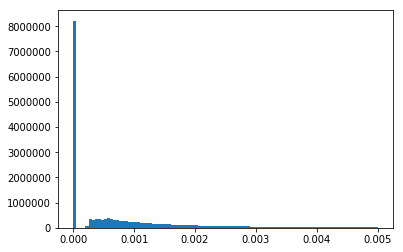

In [223]:
params = []
plt.figure()
for p in model.parameters():
    params.extend(list(p.data.cpu().abs().numpy().flatten()))
plt.hist(params,bins=100,range=[0, .0050])
plt.show()
        

In [160]:
print prune.loss_over_time

[0.0, 0.06519370049238205, 0.027210239917039872, 0.024947272896766664, 0.04021167093515396, 0.02219086182117462, 0.03855616757273674, 0.029483978897333146, 0.02747856941819191, 0.029650130182504654, 0.0289094475209713, 0.027880735576152803, 0.02211495691537857, 0.0267302263379097, 0.01549170196056366, 0.010982877552509308, 0.011556854128837585, 0.009122861206531524, 0.015923032760620116, 0.00663828307390213, 0.011139070212841034, 0.020859219312667848, 0.012059581518173218, 0.032847846925258634, 0.027926816046237944, 0.031210372924804688, 0.013409012377262115, 0.01716043093800545, 0.024219381004571914, 0.018160417020320892, 0.013005426228046417, 0.012911151707172394, 0.017930708199739458, 0.01750793582201004, 0.031143056094646453, 0.04311732774972916, 0.04008971464633942, 0.0270072041451931, 0.018954834401607515, 0.018932074666023254, 0.016342886596918106, 0.025664503395557405, 0.02766636884212494, 0.021070078253746034, 0.0250552698969841, 0.0267739816904068, 0.04334686151146889, 0.0271

In [221]:
import pickle
with open('lossnew.pkl', 'wb') as f:
    pickle.dump(prune.loss_over_time, f)

In [222]:
import pickle
with open('sparsenew.pkl', 'wb') as f:
    pickle.dump(prune.sparsity_over_time, f)

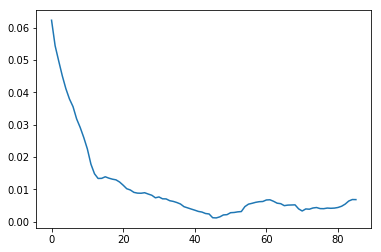

In [248]:
N=15
a =np.convolve(prune.loss_over_time[1:], np.ones((N,))/N, mode='valid')
%matplotlib inline
plt.figure()
plt.plot(range(len(a)),a)

In [314]:
g4 = [.13,.05,.02,.02,.02,.01,.015,.015,.02,.012]
g75 = [.13,.03,.015,.015,.02,.035,.04,.03,.014,.01]
ng75 = [.8,.5,.3,.26,.15,.12,.092,.053,.022,.022]
ng40 = [.8,.4,.33,.26,.15,.12,.092,.053,.022,.022]

Text(0,0.5,u'Loss (Cross Entropy)')

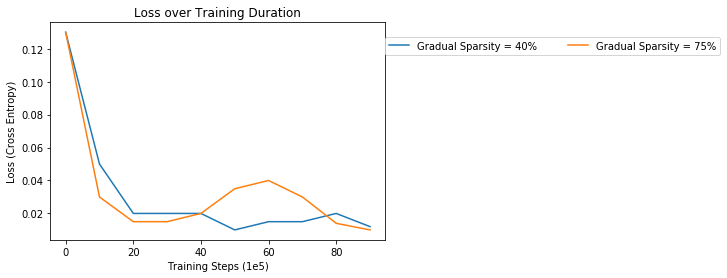

In [316]:
%matplotlib inline
plt.figure()
plt.plot(np.arange(10)*10,g4,label = "Gradual Sparsity = 40%")
plt.plot(np.arange(10)*10,g75,label = "Gradual Sparsity = 75%")
#plt.plot(np.arange(10)*10,ng75,label = "Non-Gradual Sparsity = 75%")
#plt.plot(np.arange(10)*10,ng40,label = "Non-Gradual Sparsity = 75%")

plt.legend(bbox_to_anchor=(1., .85, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Loss over Training Duration")
plt.xlabel("Training Steps (1e5)")
plt.ylabel("Loss (Cross Entropy)")


In [257]:
import pickle
c=None
with open('loss1.pkl', 'r') as f:
     c= pickle.load(f)

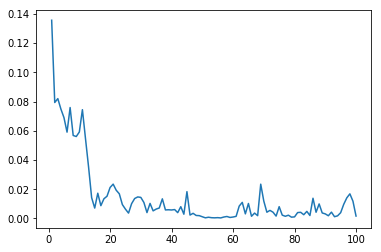

In [229]:
%matplotlib inline
plt.figure()
plt.plot(range(len(prune.loss_over_time))[1:],prune.loss_over_time[1:])

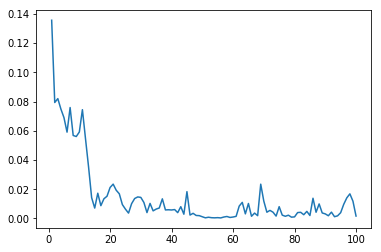

In [244]:
%matplotlib inline
plt.figure()
plt.plot(range(len(prune.loss_over_time))[1:],prune.loss_over_time[1:])

In [281]:
p = np.arange(len(prune.sparsity_over_time))*1000.
f=.75-.75*(1-(p/(100*1000)))**3

Text(0,0.5,u'Sparsity (%)')

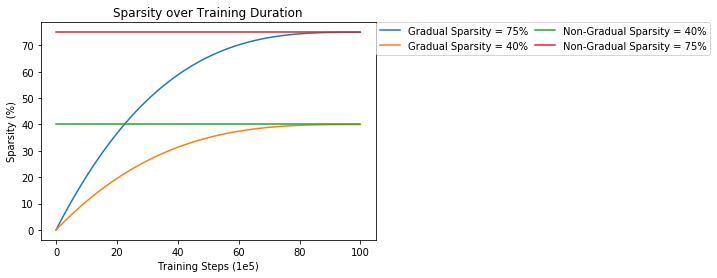

In [290]:
plt.figure()
plt.plot(range(len(prune.sparsity_over_time)),np.array(f)*100,label = "Gradual Sparsity = 75%")
plt.plot(range(len(prune.sparsity_over_time)),np.array(prune.sparsity_over_time)*100,label="Gradual Sparsity = 40%")
plt.plot(range(len(prune.sparsity_over_time)),np.repeat(40,len(prune.sparsity_over_time)),label = "Non-Gradual Sparsity = 40%")
plt.plot(range(len(prune.sparsity_over_time)),np.repeat(75,len(prune.sparsity_over_time)),label = "Non-Gradual Sparsity = 75%")
plt.legend(bbox_to_anchor=(1., .85, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Sparsity over Training Duration")
plt.xlabel("Training Steps (1e5)")
plt.ylabel("Sparsity (%)")

In [228]:
prune.test(testloader)

0.9194

In [227]:
prune.train()#nonzeros vs zeroing out in forward pass

current sparsity: 0.4
sparsity target: 0.4
initial sparsity: 0
current train step: 150000
prune steps: 100
prunning rate: 1000
None
epoch:  0
0.4
150000
5.17805814743e-05
Layer 1 | Conv layer | 40.91% parameters pruned
Layer 2 | Conv layer | 40.05% parameters pruned
Layer 3 | Conv layer | 40.04% parameters pruned
Layer 4 | Conv layer | 40.02% parameters pruned
Layer 5 | Conv layer | 40.01% parameters pruned
Layer 6 | Conv layer | 40.01% parameters pruned
Layer 7 | Conv layer | 40.01% parameters pruned
Layer 8 | Conv layer | 40.01% parameters pruned
Layer 9 | Conv layer | 40.02% parameters pruned
Layer 10 | Conv layer | 40.01% parameters pruned
Layer 11 | Conv layer | 40.01% parameters pruned
Layer 12 | Conv layer | 40.01% parameters pruned
Layer 13 | Conv layer | 40.01% parameters pruned
Layer 14 | Conv layer | 40.01% parameters pruned
Layer 15 | Conv layer | 40.01% parameters pruned
Layer 16 | Conv layer | 40.01% parameters pruned
Layer 17 | Linear layer | 40.05% parameters pruned
Lay

159000
3.24189662933e-05
Layer 1 | Conv layer | 40.91% parameters pruned
Layer 2 | Conv layer | 40.05% parameters pruned
Layer 3 | Conv layer | 40.04% parameters pruned
Layer 4 | Conv layer | 40.02% parameters pruned
Layer 5 | Conv layer | 40.01% parameters pruned
Layer 6 | Conv layer | 40.01% parameters pruned
Layer 7 | Conv layer | 40.01% parameters pruned
Layer 8 | Conv layer | 40.01% parameters pruned
Layer 9 | Conv layer | 40.02% parameters pruned
Layer 10 | Conv layer | 40.01% parameters pruned
Layer 11 | Conv layer | 40.01% parameters pruned
Layer 12 | Conv layer | 40.01% parameters pruned
Layer 13 | Conv layer | 40.01% parameters pruned
Layer 14 | Conv layer | 40.01% parameters pruned
Layer 15 | Conv layer | 40.01% parameters pruned
Layer 16 | Conv layer | 40.01% parameters pruned
Layer 17 | Linear layer | 40.05% parameters pruned
Layer 18 | Linear layer | 40.03% parameters pruned
Layer 19 | Linear layer | 40.06% parameters pruned
Final pruning rate: 40.00%
39.9973076882
160000

167000
3.52668762207e-05
Layer 1 | Conv layer | 40.91% parameters pruned
Layer 2 | Conv layer | 40.05% parameters pruned
Layer 3 | Conv layer | 40.04% parameters pruned
Layer 4 | Conv layer | 40.02% parameters pruned
Layer 5 | Conv layer | 40.01% parameters pruned
Layer 6 | Conv layer | 40.01% parameters pruned
Layer 7 | Conv layer | 40.01% parameters pruned
Layer 8 | Conv layer | 40.01% parameters pruned
Layer 9 | Conv layer | 40.02% parameters pruned
Layer 10 | Conv layer | 40.01% parameters pruned
Layer 11 | Conv layer | 40.01% parameters pruned
Layer 12 | Conv layer | 40.01% parameters pruned
Layer 13 | Conv layer | 40.01% parameters pruned
Layer 14 | Conv layer | 40.01% parameters pruned
Layer 15 | Conv layer | 40.01% parameters pruned
Layer 16 | Conv layer | 40.01% parameters pruned
Layer 17 | Linear layer | 40.05% parameters pruned
Layer 18 | Linear layer | 40.03% parameters pruned
Layer 19 | Linear layer | 40.06% parameters pruned
Final pruning rate: 40.00%
39.9973076882
168000

0.9186
current sparsity: 0.4
sparsity target: 0.4
initial sparsity: 0
current train step: 175000
prune steps: 100
prunning rate: 1000
None
epoch:  2
0.4
175000
3.89077663422e-05
Layer 1 | Conv layer | 40.91% parameters pruned
Layer 2 | Conv layer | 40.05% parameters pruned
Layer 3 | Conv layer | 40.04% parameters pruned
Layer 4 | Conv layer | 40.02% parameters pruned
Layer 5 | Conv layer | 40.01% parameters pruned
Layer 6 | Conv layer | 40.01% parameters pruned
Layer 7 | Conv layer | 40.01% parameters pruned
Layer 8 | Conv layer | 40.01% parameters pruned
Layer 9 | Conv layer | 40.02% parameters pruned
Layer 10 | Conv layer | 40.01% parameters pruned
Layer 11 | Conv layer | 40.01% parameters pruned
Layer 12 | Conv layer | 40.01% parameters pruned
Layer 13 | Conv layer | 40.01% parameters pruned
Layer 14 | Conv layer | 40.01% parameters pruned
Layer 15 | Conv layer | 40.01% parameters pruned
Layer 16 | Conv layer | 40.01% parameters pruned
Layer 17 | Linear layer | 40.05% parameters pru

184000
3.25539112091e-05
Layer 1 | Conv layer | 40.91% parameters pruned
Layer 2 | Conv layer | 40.05% parameters pruned
Layer 3 | Conv layer | 40.04% parameters pruned
Layer 4 | Conv layer | 40.02% parameters pruned
Layer 5 | Conv layer | 40.01% parameters pruned
Layer 6 | Conv layer | 40.01% parameters pruned
Layer 7 | Conv layer | 40.01% parameters pruned
Layer 8 | Conv layer | 40.01% parameters pruned
Layer 9 | Conv layer | 40.02% parameters pruned
Layer 10 | Conv layer | 40.01% parameters pruned
Layer 11 | Conv layer | 40.01% parameters pruned
Layer 12 | Conv layer | 40.01% parameters pruned
Layer 13 | Conv layer | 40.01% parameters pruned
Layer 14 | Conv layer | 40.01% parameters pruned
Layer 15 | Conv layer | 40.01% parameters pruned
Layer 16 | Conv layer | 40.01% parameters pruned
Layer 17 | Linear layer | 40.05% parameters pruned
Layer 18 | Linear layer | 40.03% parameters pruned
Layer 19 | Linear layer | 40.06% parameters pruned
Final pruning rate: 40.00%
39.9973076882
185000

192000
2.96337604523e-05
Layer 1 | Conv layer | 40.91% parameters pruned
Layer 2 | Conv layer | 40.05% parameters pruned
Layer 3 | Conv layer | 40.04% parameters pruned
Layer 4 | Conv layer | 40.02% parameters pruned
Layer 5 | Conv layer | 40.01% parameters pruned
Layer 6 | Conv layer | 40.01% parameters pruned
Layer 7 | Conv layer | 40.01% parameters pruned
Layer 8 | Conv layer | 40.01% parameters pruned
Layer 9 | Conv layer | 40.02% parameters pruned
Layer 10 | Conv layer | 40.01% parameters pruned
Layer 11 | Conv layer | 40.01% parameters pruned
Layer 12 | Conv layer | 40.01% parameters pruned
Layer 13 | Conv layer | 40.01% parameters pruned
Layer 14 | Conv layer | 40.01% parameters pruned
Layer 15 | Conv layer | 40.01% parameters pruned
Layer 16 | Conv layer | 40.01% parameters pruned
Layer 17 | Linear layer | 40.05% parameters pruned
Layer 18 | Linear layer | 40.03% parameters pruned
Layer 19 | Linear layer | 40.06% parameters pruned
Final pruning rate: 40.00%
39.9973076882
193000

0.9188
current sparsity: 0.4
sparsity target: 0.4
initial sparsity: 0
current train step: 200000
prune steps: 100
prunning rate: 1000
None
epoch:  4
0.4
200000
3.01897525787e-05
Layer 1 | Conv layer | 40.91% parameters pruned
Layer 2 | Conv layer | 40.05% parameters pruned
Layer 3 | Conv layer | 40.04% parameters pruned
Layer 4 | Conv layer | 40.02% parameters pruned
Layer 5 | Conv layer | 40.01% parameters pruned
Layer 6 | Conv layer | 40.01% parameters pruned
Layer 7 | Conv layer | 40.01% parameters pruned
Layer 8 | Conv layer | 40.01% parameters pruned
Layer 9 | Conv layer | 40.02% parameters pruned
Layer 10 | Conv layer | 40.01% parameters pruned
Layer 11 | Conv layer | 40.01% parameters pruned
Layer 12 | Conv layer | 40.01% parameters pruned
Layer 13 | Conv layer | 40.01% parameters pruned
Layer 14 | Conv layer | 40.01% parameters pruned
Layer 15 | Conv layer | 40.01% parameters pruned
Layer 16 | Conv layer | 40.01% parameters pruned
Layer 17 | Linear layer | 40.05% parameters pru

209000
2.52664089203e-05
Layer 1 | Conv layer | 40.91% parameters pruned
Layer 2 | Conv layer | 40.05% parameters pruned
Layer 3 | Conv layer | 40.04% parameters pruned
Layer 4 | Conv layer | 40.02% parameters pruned
Layer 5 | Conv layer | 40.01% parameters pruned
Layer 6 | Conv layer | 40.01% parameters pruned
Layer 7 | Conv layer | 40.01% parameters pruned
Layer 8 | Conv layer | 40.01% parameters pruned
Layer 9 | Conv layer | 40.02% parameters pruned
Layer 10 | Conv layer | 40.01% parameters pruned
Layer 11 | Conv layer | 40.01% parameters pruned
Layer 12 | Conv layer | 40.01% parameters pruned
Layer 13 | Conv layer | 40.01% parameters pruned
Layer 14 | Conv layer | 40.01% parameters pruned
Layer 15 | Conv layer | 40.01% parameters pruned
Layer 16 | Conv layer | 40.01% parameters pruned
Layer 17 | Linear layer | 40.05% parameters pruned
Layer 18 | Linear layer | 40.03% parameters pruned
Layer 19 | Linear layer | 40.06% parameters pruned
Final pruning rate: 40.00%
39.9973076882
210000

217000
2.78217792511e-05
Layer 1 | Conv layer | 40.91% parameters pruned
Layer 2 | Conv layer | 40.05% parameters pruned
Layer 3 | Conv layer | 40.04% parameters pruned
Layer 4 | Conv layer | 40.02% parameters pruned
Layer 5 | Conv layer | 40.01% parameters pruned
Layer 6 | Conv layer | 40.01% parameters pruned
Layer 7 | Conv layer | 40.01% parameters pruned
Layer 8 | Conv layer | 40.01% parameters pruned
Layer 9 | Conv layer | 40.02% parameters pruned
Layer 10 | Conv layer | 40.01% parameters pruned
Layer 11 | Conv layer | 40.01% parameters pruned
Layer 12 | Conv layer | 40.01% parameters pruned
Layer 13 | Conv layer | 40.01% parameters pruned
Layer 14 | Conv layer | 40.01% parameters pruned
Layer 15 | Conv layer | 40.01% parameters pruned
Layer 16 | Conv layer | 40.01% parameters pruned
Layer 17 | Linear layer | 40.05% parameters pruned
Layer 18 | Linear layer | 40.03% parameters pruned
Layer 19 | Linear layer | 40.06% parameters pruned
Final pruning rate: 40.00%
39.9973076882
218000

0.919
current sparsity: 0.4
sparsity target: 0.4
initial sparsity: 0
current train step: 225000
prune steps: 100
prunning rate: 1000
None
epoch:  6
0.4
225000
2.40788459778e-05
Layer 1 | Conv layer | 40.91% parameters pruned
Layer 2 | Conv layer | 40.05% parameters pruned
Layer 3 | Conv layer | 40.04% parameters pruned
Layer 4 | Conv layer | 40.02% parameters pruned
Layer 5 | Conv layer | 40.01% parameters pruned
Layer 6 | Conv layer | 40.01% parameters pruned
Layer 7 | Conv layer | 40.01% parameters pruned
Layer 8 | Conv layer | 40.01% parameters pruned
Layer 9 | Conv layer | 40.02% parameters pruned
Layer 10 | Conv layer | 40.01% parameters pruned
Layer 11 | Conv layer | 40.01% parameters pruned
Layer 12 | Conv layer | 40.01% parameters pruned
Layer 13 | Conv layer | 40.01% parameters pruned
Layer 14 | Conv layer | 40.01% parameters pruned
Layer 15 | Conv layer | 40.01% parameters pruned
Layer 16 | Conv layer | 40.01% parameters pruned
Layer 17 | Linear layer | 40.05% parameters prun

234000
2.22373008728e-05
Layer 1 | Conv layer | 40.91% parameters pruned
Layer 2 | Conv layer | 40.05% parameters pruned
Layer 3 | Conv layer | 40.04% parameters pruned
Layer 4 | Conv layer | 40.02% parameters pruned
Layer 5 | Conv layer | 40.01% parameters pruned
Layer 6 | Conv layer | 40.01% parameters pruned
Layer 7 | Conv layer | 40.01% parameters pruned
Layer 8 | Conv layer | 40.01% parameters pruned
Layer 9 | Conv layer | 40.02% parameters pruned
Layer 10 | Conv layer | 40.01% parameters pruned
Layer 11 | Conv layer | 40.01% parameters pruned
Layer 12 | Conv layer | 40.01% parameters pruned
Layer 13 | Conv layer | 40.01% parameters pruned
Layer 14 | Conv layer | 40.01% parameters pruned
Layer 15 | Conv layer | 40.01% parameters pruned
Layer 16 | Conv layer | 40.01% parameters pruned
Layer 17 | Linear layer | 40.05% parameters pruned
Layer 18 | Linear layer | 40.03% parameters pruned
Layer 19 | Linear layer | 40.06% parameters pruned
Final pruning rate: 40.00%
39.9973076882
235000

242000
1.9109249115e-05
Layer 1 | Conv layer | 40.91% parameters pruned
Layer 2 | Conv layer | 40.05% parameters pruned
Layer 3 | Conv layer | 40.04% parameters pruned
Layer 4 | Conv layer | 40.02% parameters pruned
Layer 5 | Conv layer | 40.01% parameters pruned
Layer 6 | Conv layer | 40.01% parameters pruned
Layer 7 | Conv layer | 40.01% parameters pruned
Layer 8 | Conv layer | 40.01% parameters pruned
Layer 9 | Conv layer | 40.02% parameters pruned
Layer 10 | Conv layer | 40.01% parameters pruned
Layer 11 | Conv layer | 40.01% parameters pruned
Layer 12 | Conv layer | 40.01% parameters pruned
Layer 13 | Conv layer | 40.01% parameters pruned
Layer 14 | Conv layer | 40.01% parameters pruned
Layer 15 | Conv layer | 40.01% parameters pruned
Layer 16 | Conv layer | 40.01% parameters pruned
Layer 17 | Linear layer | 40.05% parameters pruned
Layer 18 | Linear layer | 40.03% parameters pruned
Layer 19 | Linear layer | 40.06% parameters pruned
Final pruning rate: 40.00%
39.9973076882
243000


0.9192
current sparsity: 0.4
sparsity target: 0.4
initial sparsity: 0
current train step: 250000
prune steps: 100
prunning rate: 1000
None
epoch:  8
0.4
250000
1.79998874664e-05
Layer 1 | Conv layer | 40.91% parameters pruned
Layer 2 | Conv layer | 40.05% parameters pruned
Layer 3 | Conv layer | 40.04% parameters pruned
Layer 4 | Conv layer | 40.02% parameters pruned
Layer 5 | Conv layer | 40.01% parameters pruned
Layer 6 | Conv layer | 40.01% parameters pruned
Layer 7 | Conv layer | 40.01% parameters pruned
Layer 8 | Conv layer | 40.01% parameters pruned
Layer 9 | Conv layer | 40.02% parameters pruned
Layer 10 | Conv layer | 40.01% parameters pruned
Layer 11 | Conv layer | 40.01% parameters pruned
Layer 12 | Conv layer | 40.01% parameters pruned
Layer 13 | Conv layer | 40.01% parameters pruned
Layer 14 | Conv layer | 40.01% parameters pruned
Layer 15 | Conv layer | 40.01% parameters pruned
Layer 16 | Conv layer | 40.01% parameters pruned
Layer 17 | Linear layer | 40.05% parameters pru

259000
1.78098678589e-05
Layer 1 | Conv layer | 40.91% parameters pruned
Layer 2 | Conv layer | 40.05% parameters pruned
Layer 3 | Conv layer | 40.04% parameters pruned
Layer 4 | Conv layer | 40.02% parameters pruned
Layer 5 | Conv layer | 40.01% parameters pruned
Layer 6 | Conv layer | 40.01% parameters pruned
Layer 7 | Conv layer | 40.01% parameters pruned
Layer 8 | Conv layer | 40.01% parameters pruned
Layer 9 | Conv layer | 40.02% parameters pruned
Layer 10 | Conv layer | 40.01% parameters pruned
Layer 11 | Conv layer | 40.01% parameters pruned
Layer 12 | Conv layer | 40.01% parameters pruned
Layer 13 | Conv layer | 40.01% parameters pruned
Layer 14 | Conv layer | 40.01% parameters pruned
Layer 15 | Conv layer | 40.01% parameters pruned
Layer 16 | Conv layer | 40.01% parameters pruned
Layer 17 | Linear layer | 40.05% parameters pruned
Layer 18 | Linear layer | 40.03% parameters pruned
Layer 19 | Linear layer | 40.06% parameters pruned
Final pruning rate: 40.00%
39.9973076882
260000

267000
1.5082359314e-05
Layer 1 | Conv layer | 40.91% parameters pruned
Layer 2 | Conv layer | 40.05% parameters pruned
Layer 3 | Conv layer | 40.04% parameters pruned
Layer 4 | Conv layer | 40.02% parameters pruned
Layer 5 | Conv layer | 40.01% parameters pruned
Layer 6 | Conv layer | 40.01% parameters pruned
Layer 7 | Conv layer | 40.01% parameters pruned
Layer 8 | Conv layer | 40.01% parameters pruned
Layer 9 | Conv layer | 40.02% parameters pruned
Layer 10 | Conv layer | 40.01% parameters pruned
Layer 11 | Conv layer | 40.01% parameters pruned
Layer 12 | Conv layer | 40.01% parameters pruned
Layer 13 | Conv layer | 40.01% parameters pruned
Layer 14 | Conv layer | 40.01% parameters pruned
Layer 15 | Conv layer | 40.01% parameters pruned
Layer 16 | Conv layer | 40.01% parameters pruned
Layer 17 | Linear layer | 40.05% parameters pruned
Layer 18 | Linear layer | 40.03% parameters pruned
Layer 19 | Linear layer | 40.06% parameters pruned
Final pruning rate: 40.00%
39.9973076882
268000


0.9194
Finished fine tuning.
Time elapsed:5641.86156392


In [140]:
import torch.utils.model_zoo as model_zoo
vgg_model1 = vgg19()
#sd = torch.load('/home/drc/Downloads/model_best.pth.tar')
vgg_model1.load_state_dict(w)
vgg_model1 = vgg_model1.cuda()
import copy
model1 = copy.deepcopy(vgg_model1)

In [141]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

In [142]:
def prune(model,target):#all conv layers for now
        for seq in list(model.children()):
            for layer in seq:
                if isinstance(layer, MaskedLinear) or isinstance(layer, MaskedConv2d):
                    #find weight threshold for layer
                    weight_threshold = get_weight_threshold(layer.parameters(),target) 
                    #set mask
                    mask = get_prune_mask(layer,weight_threshold)
                    #prune
                    layer.set_mask(mask)
        
def get_prune_mask(layer,threshold):
        # generate mask
        p=layer.weight.data.abs()
        pruned_inds = p > threshold
        return pruned_inds.float()

        
def get_weight_threshold(params,percent_to_prune):
        weights=[]
        for param in params:
            if len(list(param.cpu().data.abs().numpy().flatten()))>1:
                weights.extend(list(param.cpu().data.abs().numpy().flatten()))
        threshold = np.percentile(np.array(weights),percent_to_prune*100)
        #print len(np.nonzero(np.array(weights)))/float(len(weights))
        return threshold
    
test(model1,testloader)

# prune the weights
prune(model1,.75)
test(model1, testloader)

Test accuracy: 80.70% (8070/10000)
Test accuracy: 64.71% (6471/10000)


0.6471

In [143]:
prune_rate(model1)

Layer 1 | Conv layer | 76.50% parameters pruned
Layer 2 | Conv layer | 75.08% parameters pruned
Layer 3 | Conv layer | 75.06% parameters pruned
Layer 4 | Conv layer | 75.03% parameters pruned
Layer 5 | Conv layer | 75.01% parameters pruned
Layer 6 | Conv layer | 75.01% parameters pruned
Layer 7 | Conv layer | 75.02% parameters pruned
Layer 8 | Conv layer | 75.02% parameters pruned
Layer 9 | Conv layer | 75.03% parameters pruned
Layer 10 | Conv layer | 75.02% parameters pruned
Layer 11 | Conv layer | 75.02% parameters pruned
Layer 12 | Conv layer | 75.01% parameters pruned
Layer 13 | Conv layer | 75.01% parameters pruned
Layer 14 | Conv layer | 75.01% parameters pruned
Layer 15 | Conv layer | 75.01% parameters pruned
Layer 16 | Conv layer | 75.01% parameters pruned
Layer 17 | Linear layer | 75.08% parameters pruned
Layer 18 | Linear layer | 75.06% parameters pruned
Layer 19 | Linear layer | 75.06% parameters pruned
Final pruning rate: 74.99%


74.99338111643465

In [144]:
losses=[]


for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for t, (x, y) in enumerate(trainloader):
        inputs, labels = to_var(x), to_var(y.long())
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if t % 1000 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, t + 1, running_loss / 1000.))
            losses.append(running_loss/1000.)
            running_loss = 0.0

print('Finished Training')


#torch.save(net.state_dict(), 'vgg_pruned.pkl')

[1,     1] loss: 0.000
[1,  1001] loss: 0.842
[1,  2001] loss: 0.568
[1,  3001] loss: 0.510
[1,  4001] loss: 0.446
[1,  5001] loss: 0.424
[1,  6001] loss: 0.371
[1,  7001] loss: 0.381
[1,  8001] loss: 0.340
[1,  9001] loss: 0.344
[1, 10001] loss: 0.330
[1, 11001] loss: 0.321
[1, 12001] loss: 0.303
[2,     1] loss: 0.000
[2,  1001] loss: 0.202
[2,  2001] loss: 0.246
[2,  3001] loss: 0.245
[2,  4001] loss: 0.214
[2,  5001] loss: 0.225
[2,  6001] loss: 0.224
[2,  7001] loss: 0.208
[2,  8001] loss: 0.207
[2,  9001] loss: 0.186
[2, 10001] loss: 0.194
[2, 11001] loss: 0.224
[2, 12001] loss: 0.225
[3,     1] loss: 0.000
[3,  1001] loss: 0.139
[3,  2001] loss: 0.130
[3,  3001] loss: 0.137
[3,  4001] loss: 0.150
[3,  5001] loss: 0.141
[3,  6001] loss: 0.196
[3,  7001] loss: 0.141
[3,  8001] loss: 0.169
[3,  9001] loss: 0.166
[3, 10001] loss: 0.152
[3, 11001] loss: 0.145
[3, 12001] loss: 0.156
[4,     1] loss: 0.000
[4,  1001] loss: 0.100
[4,  2001] loss: 0.095
[4,  3001] loss: 0.112
[4,  4001] 

In [145]:
test(model1, testloader)

Test accuracy: 89.40% (8940/10000)


0.894

In [147]:
prune_rate(model1)

Layer 1 | Conv layer | 76.50% parameters pruned
Layer 2 | Conv layer | 75.08% parameters pruned
Layer 3 | Conv layer | 75.06% parameters pruned
Layer 4 | Conv layer | 75.03% parameters pruned
Layer 5 | Conv layer | 75.01% parameters pruned
Layer 6 | Conv layer | 75.01% parameters pruned
Layer 7 | Conv layer | 75.02% parameters pruned
Layer 8 | Conv layer | 75.02% parameters pruned
Layer 9 | Conv layer | 75.03% parameters pruned
Layer 10 | Conv layer | 75.02% parameters pruned
Layer 11 | Conv layer | 75.02% parameters pruned
Layer 12 | Conv layer | 75.01% parameters pruned
Layer 13 | Conv layer | 75.01% parameters pruned
Layer 14 | Conv layer | 75.01% parameters pruned
Layer 15 | Conv layer | 75.01% parameters pruned
Layer 16 | Conv layer | 75.01% parameters pruned
Layer 17 | Linear layer | 75.08% parameters pruned
Layer 18 | Linear layer | 75.06% parameters pruned
Layer 19 | Linear layer | 75.06% parameters pruned
Final pruning rate: 74.99%


74.99338111643465

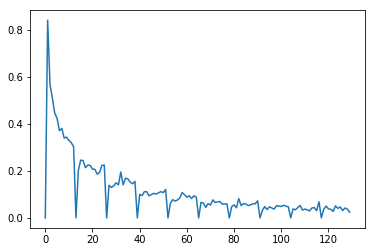

In [146]:
plt.figure()
plt.plot(losses)

### adapted from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py

notes:

questions?:
    1. Data involved or data agnostic
    2. during training or after
    3. Inference citeria, or backprop criteria.
    4. at what point during training do you prune
    5. using gradient and activation signals if one is high
    6. train from scratch work or need long burn in time
    7. VGG is notoriously slow to train with large memory footprint, what about squeeznet, arcitectures that are just better
    8. layerwise or globally
    9. when using speed as metric have to make sure your prunning method is super efficient
 Channel-wise
 10. if not layerwise how do params get masked over time, in what layersc
SSL [49] reaches high compression ratio for first few conv
layers of LeNet [30] and AlexNet [26]. [54] could work
well for fully connected layers. However, training-based
approaches are more costly, and the effectiveness for very
deep networks on large datasets is rarely exploited

